In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
from random import sample

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import fnmatch
import os
print (len(fnmatch.filter(os.listdir("flower/daisy"), '*.jpg')))
print (len(fnmatch.filter(os.listdir("flower/rose"), '*.jpg')))
print (len(fnmatch.filter(os.listdir("flower/tulip"), '*.jpg')))
print (len(fnmatch.filter(os.listdir("flower/sunflower"), '*.jpg')))

768
784
984
734


In [3]:
batch_size=32
root='flower'

# ? transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
size=len(dataset)
classes=dataset.classes

# Pick 70% data randomly into trainset
train_index = sample(range(size),int(size*0.70))
train_index.sort()
trainset = []
for i in train_index:
    trainset.append(dataset[i])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# Find the index for the remaining subset
remaining=[]
t_count=0
r_count=0
while t_count<len(train_index):
    while train_index[t_count]>r_count:
        remaining.append(r_count)
        r_count+=1
    t_count+=1
    r_count+=1
while r_count<len(dataset):
    remaining.append(r_count)
    r_count+=1
# Pick 20% data randomly into valset
val_index = sample(range(len(remaining)),int(len(dataset)*0.20))
val_index.sort()
valset = []
for i in val_index:
    valset.append(dataset[remaining[i]])
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
# Put the remaining into testset
testset=[]
v_count=0
r_count=0
test_index=[]
while v_count<len(val_index):
    while val_index[v_count]>r_count:
        testset.append(dataset[remaining[r_count]])
        test_index.append(r_count)
        r_count+=1
    v_count+=1
    r_count+=1
while r_count<len(remaining):
    testset.append(dataset[remaining[r_count]])
    test_index.append(r_count)
    r_count+=1
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [4]:
print("(trainset,valset,testset)=({0},{1},{2})".format(len(train_index),len(val_index),len(test_index)))
#Check if we divide the set properly
#print(train_index[:10])
#print(remaining[:10])
#print(val_index[:10])
#print(test_index[:10])

(trainset,valset,testset)=(2289,654,327)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


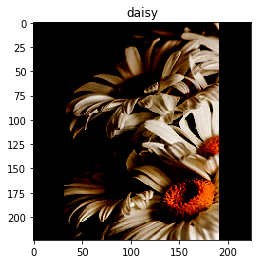

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


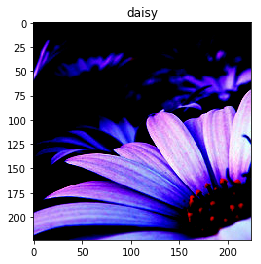

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


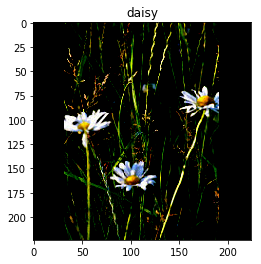

In [5]:
for image, label in testset[:3]:
    plt.title(classes[label])
    # plt needs the channel in dim2
    plt.imshow(image.permute(1,2,0))
    plt.show()

In [6]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim,hidden_dim)
        self.relu=nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, data):
  
        x=self.fc1(data)
       
        x=self.relu(x)
        x=self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

In [7]:
EPOCHS = 50
LEARNING_RATE = 0.001
INPUT_SIZE = 224*224*3
HIDDEN_SIZE = 20

OUTPUT_SIZE = 4

net = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

### Define an optimizer and a loss function here. We pass our network parameters to our optimizer here so we know
### which values to update by how much.
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

print(net)

for epoch in range(EPOCHS):
    
    total_loss = 0
    
    for images, labels in trainloader:
                
        ### YOUR CODE HERE - Zero gradients, call .backward(), and step the optimizer.
        images=images.view(images.shape[0],-1).float()
        images.require_grad=True
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
                
        total_loss += loss.item()
        
    average_loss = total_loss / len(trainloader)
    
    ### Calculate validation accuracy here by iterating through the validation set.
    ### We use torch.no_grad() here because we don't want to accumulate gradients in our function.
    with torch.no_grad():
        correction=0.0
        for images,labels in valloader:
            images=images.view(images.shape[0],-1).float()
            val_output = net(images)
            val_output = torch.argmax(val_output.reshape(val_output.shape[0], -1), dim=1)
            correction += torch.sum(val_output == labels).item() / float(val_output.shape[0])
        val_acc=correction/len(valloader)
    print("(epoch, train_loss, val_acc) = ({0}, {1}, {2})".format(epoch, average_loss, val_acc))

NeuralNet(
  (fc1): Linear(in_features=150528, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=4, bias=True)
)
(epoch, train_loss, val_acc) = (0, 3.8875742273198233, 0.27763605442176875)
(epoch, train_loss, val_acc) = (1, 2.231750557820002, 0.38052721088435376)
(epoch, train_loss, val_acc) = (2, 1.869126004477342, 0.36883503401360546)
(epoch, train_loss, val_acc) = (3, 1.425468545820978, 0.46577380952380953)
(epoch, train_loss, val_acc) = (4, 1.3397937367359798, 0.45344387755102045)
(epoch, train_loss, val_acc) = (5, 1.1631793338391516, 0.47151360544217685)
(epoch, train_loss, val_acc) = (6, 1.0640545073482726, 0.5012755102040816)
(epoch, train_loss, val_acc) = (7, 1.0314194046788745, 0.48405612244897955)
(epoch, train_loss, val_acc) = (8, 0.9161231161819564, 0.4523809523809524)
(epoch, train_loss, val_acc) = (9, 1.0074531046880617, 0.46726190476190477)
(epoch, train_loss, val_acc) = (

[[0.4875     0.1125     0.1375     0.2625    ]
 [0.15555556 0.5        0.03333333 0.31111111]
 [0.11111111 0.01388889 0.59722222 0.27777778]
 [0.14117647 0.12941176 0.2        0.52941176]]
Test accuracy: 0.5190746753246753


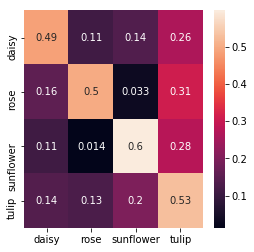

In [10]:
# calculate accuracy
correction=0.0
pred=np.array([])
target=np.array([])
for images,labels in testloader:
    images=images.view(images.shape[0],-1).float()
    test_output = net(images)
    test_output = torch.argmax(test_output.reshape(test_output.shape[0], -1), dim=1)
    pred=np.concatenate((pred,test_output))
    target=np.concatenate((target,labels))
    correction += torch.sum(test_output == labels).item()/ float(test_output.shape[0])
test_acc=correction/len(testloader)
# confusion matrix
cm=confusion_matrix(target,pred)
cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm,classes,classes)
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True)
print(cm)
print("Test accuracy:", test_acc)